In [39]:
# Standard imports
import os
import cv2
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

Data Processing

In [40]:
df = pd.read_csv('nba2.csv')
df = df.dropna() # drop NAs
df = df.iloc[:, 6:] 

df.head()

,W/L%,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,...,O_FTA,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS
0,0.439,242.1,43.0,92.5,29.3,54.8,13.7,37.7,18.5,23.2,...,21.8,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5
1,0.780,241.8,43.9,90.2,27.4,47.7,16.5,42.5,16.3,20.2,...,17.3,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2
2,0.256,240.6,40.0,87.0,28.0,53.0,12.1,34.0,14.5,18.4,...,20.7,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8
3,0.476,243.7,42.0,89.5,30.6,57.4,11.5,32.1,16.7,21.1,...,21.8,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7
4,0.585,241.5,41.8,87.2,28.3,50.4,13.5,36.8,15.6,20.4,...,21.0,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2


In [41]:
# the per game stats
X = df.iloc[:, 1:]
X.shape

(1023, 35)

In [42]:
# win percent in a season
y = df.iloc[:, 0]
y.shape

(1023,)

In [43]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_new.shape)
print(y_train.shape, y_new.shape)

(716, 35) (307, 35)
(716,) (307,)


In [44]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [45]:
# Center the data for PCA
mu = np.mean(X_train,axis = 0, keepdims = True)
X_train_tilde = X_train - mu
X_train_tilde.shape

(716, 35)

In [46]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

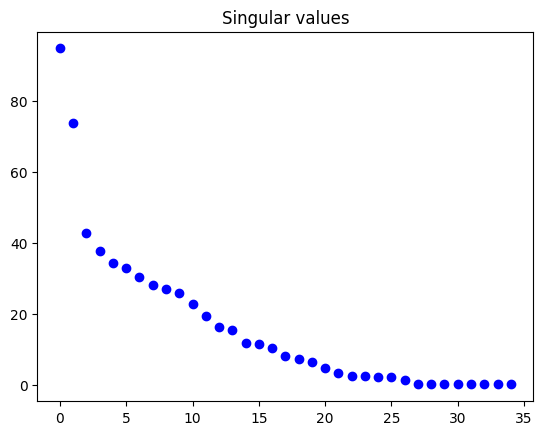

In [47]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

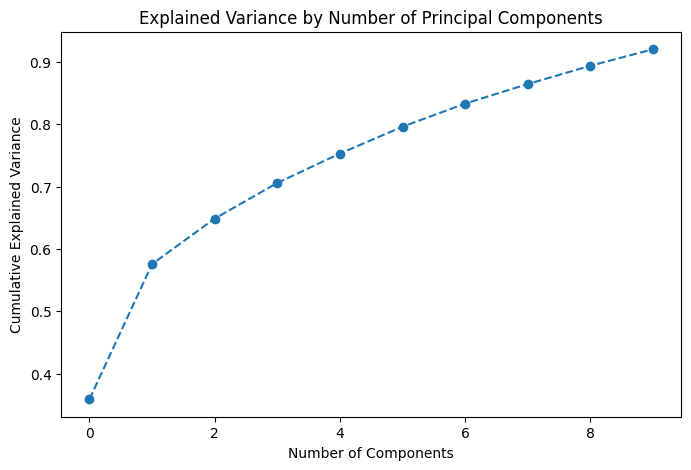

In [48]:
# PCA
pca = PCA(n_components=10)  # Using the 15 highest singular values
X_train_tilde_pca = pca.fit_transform(X_train_tilde)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.show()

In [49]:
# Transform the new data using the same steps
X_new = scaler.transform(X_new)  # Normalize
X_new_tilde = X_new - mu  # Center
X_new_tilde_pca = pca.transform(X_new_tilde)  # Apply PCA

Model Performance Comparison:
                            Model       MSE  R-squared
0               Linear Regression  0.004094   0.826378
1                Ridge Regression  0.004094   0.826391
2                Lasso Regression  0.023588  -0.000327
3                     Elastic Net  0.023588  -0.000327
4        Decision Tree Regression  0.013224   0.439199
5        Random Forest Regression  0.005535   0.765285
6    Gradient Boosting Regression  0.005188   0.779984
7       Support Vector Regression  0.005232   0.778126
8  K-Nearest Neighbors Regression  0.007061   0.700538


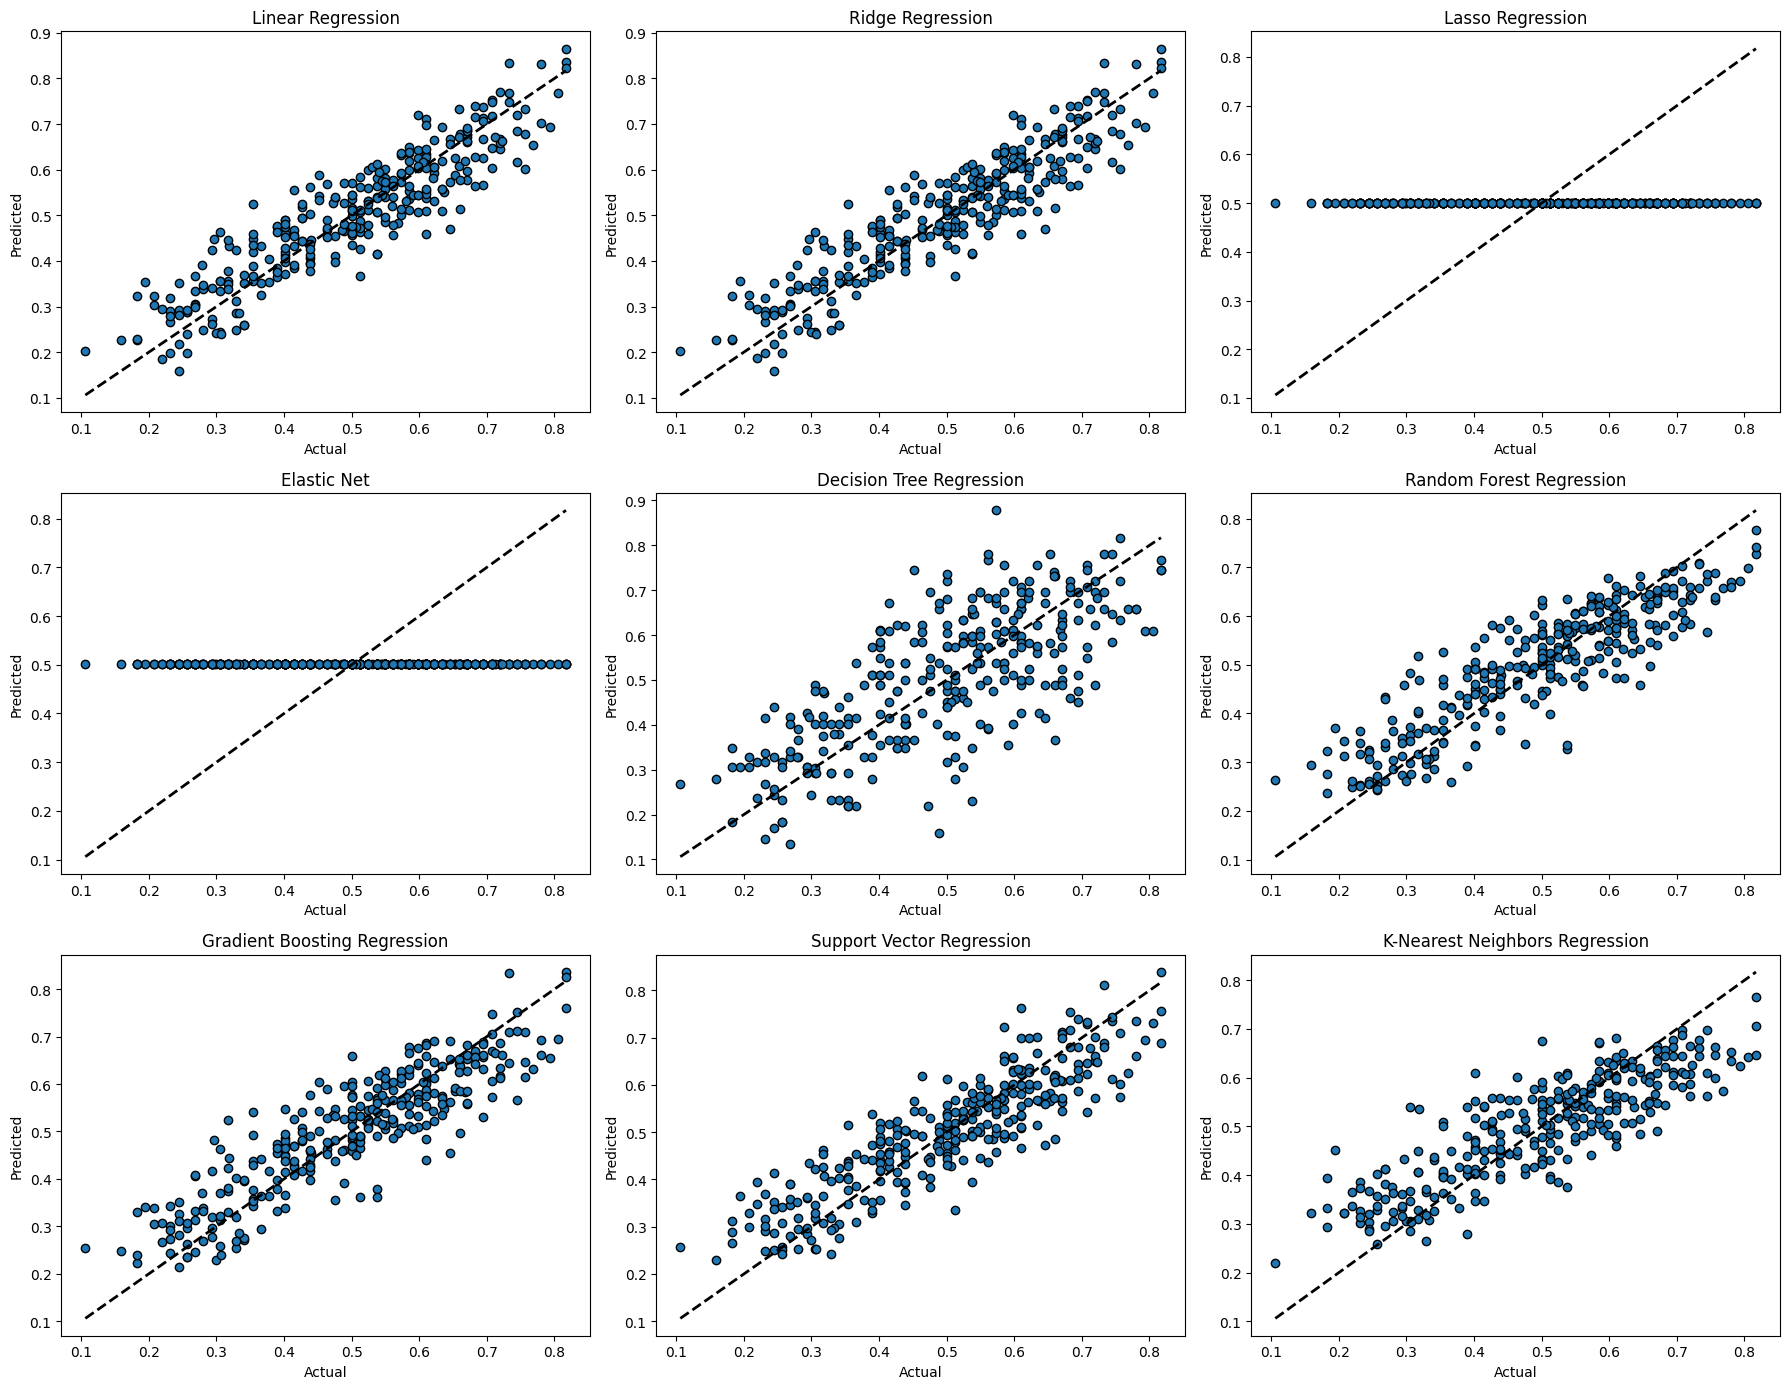

In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train_tilde_pca, y_train, X_new_tilde_pca, and y_new are defined

# Models initialization
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor()
}

# Dictionaries to store results
mse_results = {}
r2_results = {}

# Training and prediction
for name, model in models.items():
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    mse_results[name] = mean_squared_error(y_new, y_pred)
    r2_results[name] = r2_score(y_new, y_pred)

# Display results
results = pd.DataFrame({
    'Model': list(mse_results.keys()),
    'MSE': list(mse_results.values()),
    'R-squared': list(r2_results.values())
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(18, 14))

# Iterate over models for plotting
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    plt.scatter(y_new, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)

plt.tight_layout()
plt.show()